In [1]:
import torch
import numpy as np
import torchvision
from torch.nn import CrossEntropyLoss
import tqdm
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from config import get_argument
import json

In [2]:
def train(model, target_label, train_loader, param):
    print("Processing label: {}".format(target_label))

    width, height = param["image_size"]
    trigger = torch.rand((3, width, height), requires_grad=True)
    trigger = trigger.to(device).detach().requires_grad_(True)
    mask = torch.rand((width, height), requires_grad=True)
    mask = mask.to(device).detach().requires_grad_(True)

    Epochs = param["Epochs"]
    lamda = param["lamda"]

    min_norm = np.inf
    min_norm_count = 0

    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam([{"params": trigger},{"params": mask}],lr=0.005)
    model.to(device)
    model.eval()

    for epoch in range(Epochs):
        norm = 0.0
        for images, _ in tqdm.tqdm(train_loader, desc='Epoch %3d' % (epoch + 1)):
            optimizer.zero_grad()
            images = images.to(device)
            trojan_images = (1 - torch.unsqueeze(mask, dim=0)) * images + torch.unsqueeze(mask, dim=0) * trigger
            y_pred = model(trojan_images)
            y_target = torch.full((y_pred.size(0),), target_label, dtype=torch.long).to(device)
            loss = criterion(y_pred, y_target) + lamda * torch.sum(torch.abs(mask))
            loss.backward()
            optimizer.step()

            # figure norm
            with torch.no_grad():
                # 防止trigger和norm越界
                torch.clip_(trigger, 0, 1)
                torch.clip_(mask, 0, 1)
                norm = torch.sum(torch.abs(mask))

        # to early stop
        if norm < min_norm:
            min_norm = norm
            min_norm_count = 0
        else:
            min_norm_count += 1

        if min_norm_count > 30:
            break
            
    print("min norm"+str(min_norm))

    return trigger.cpu(), min_norm.cpu()

In [3]:
class augDataset_npy(torch.utils.data.Dataset):
    def __init__(self, full_dataset=None, transform=None):
        self.dataset = full_dataset
        self.transform = transform
        self.dataLen = len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index][0]
        label = self.dataset[index][1]

        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return self.dataLen

In [4]:
def reverse_engineer(model_id, para_lamda):
    param = {
        "dataset": "cifar10",
        "Epochs": 20,
        "batch_size": 64,
        "lamda": para_lamda,
        "num_classes": 10,
        "image_size": (32, 32),
        "ratio": 0.005
    }
    model = torch.load("/media/server/8961e245-931a-4871-9f74-9df58b1bd938/server/lyg/tdc-starter-kit-main/tdc_datasets/target_label_prediction/train/id-"+str(model_id)+"/model.pt").to(device)

    
    tf_train = torchvision.transforms.Compose([  
        torchvision.transforms.ToTensor(),
    ])
    
    train_dataset = torchvision.datasets.CIFAR10(root='/media/server/8961e245-931a-4871-9f74-9df58b1bd938/server/lyg/CIFAR10_GTSRB_dynamic_and_flooding/flooding/data', train=False, download=False)

    list_ = []
    count = [0]*param["num_classes"]
    threshold = int(param["ratio"]*len(train_dataset))
    for i in train_dataset:# 这段仅是用来调整个别类别的数量
        if count[i[1]] < threshold:
            list_.append(i)
            count[i[1]] += 1
    train_dataset = list_
    count = [0]*param["num_classes"]

    train_dataset = augDataset_npy(full_dataset=train_dataset, transform=tf_train)
    train_loader = DataLoader(
        train_dataset,
        batch_size = param["batch_size"],
        shuffle=False,
        num_workers=0,
        pin_memory=False,
)
    

    for label in range(param["num_classes"]):
        trigger, mask = train(model, label, train_loader, param)
        norm_list.append(mask)

        trigger = trigger.cpu().detach().numpy()
        trigger = np.transpose(trigger, (1,2,0))
        plt.axis("off")
        plt.imshow(trigger)
        plt.savefig('mask/trigger_{}.png'.format(label), bbox_inches='tight', pad_inches=0.0)

        mask = mask.cpu().detach().numpy()
        plt.axis("off")
    
    l1_norm_list = norm_list[-param["num_classes"]:]
    list_target = [0]*param["num_classes"]
    for i in range(len(list_target)):
        list_target[i] = i
    flag_label = outlier_detection(l1_norm_list, list_target)
        
    
    print("flag label:"+str(flag_label))
    return flag_label

In [5]:
def outlier_detection(l1_norm_list, idx_mapping):
    print("-" * 30)
    print("Determining whether model is backdoor")
    consistency_constant = 1.4826
    l1_norm_list = torch.tensor(l1_norm_list)
    median = torch.median(l1_norm_list)  # 返回中位数
    mad = consistency_constant * torch.median(torch.abs(l1_norm_list - median))  # 常数乘以范数减去中位数之后的中位数
    min_mad = torch.abs(torch.min(l1_norm_list) - median) / mad  # 范数中最小值减去中位数之后除以mad的绝对值

    print("Median: {}, MAD: {}".format(median, mad))
    print("Anomaly index: {}".format(min_mad))
    
    
    if min_mad < 2:  # 判断是否为后门模型
        print("Not a backdoor model")
    else:
        print("This is a backdoor model")


    flag_list = []
    for y_label in idx_mapping:  # 记录异常的类别及其mask的范数
        if l1_norm_list[idx_mapping[y_label]] > median:
            continue
        if torch.abs(l1_norm_list[idx_mapping[y_label]] - median) / mad > 2:
            flag_list.append((y_label, l1_norm_list[idx_mapping[y_label]]))

    if len(flag_list) > 0:  # 若有不少于一个异常类别，则取异常值最小的
        flag_list = sorted(flag_list, key=lambda x: x[1])
    
    if flag_list==[]:
        return float("inf")
    else:
        return flag_list[0][0]

Model ID:0001
Dataset:CIFAR-10
Processing label: 0


Epoch  20: 100%|██████████████████████████████████| 8/8 [00:00<00:00, 51.04it/s]


min normtensor(189.7893, device='cuda:0')
Processing label: 1


Epoch  20: 100%|██████████████████████████████████| 8/8 [00:00<00:00, 61.47it/s]


min normtensor(215.3327, device='cuda:0')
Processing label: 2


Epoch  20: 100%|██████████████████████████████████| 8/8 [00:00<00:00, 66.68it/s]


min normtensor(72.7280, device='cuda:0')
Processing label: 3


Epoch  20: 100%|██████████████████████████████████| 8/8 [00:00<00:00, 54.44it/s]


min normtensor(181.3761, device='cuda:0')
Processing label: 4


Epoch  20: 100%|██████████████████████████████████| 8/8 [00:00<00:00, 54.01it/s]


min normtensor(182.4987, device='cuda:0')
Processing label: 5


Epoch  20: 100%|██████████████████████████████████| 8/8 [00:00<00:00, 52.55it/s]


min normtensor(187.0743, device='cuda:0')
Processing label: 6


Epoch  20: 100%|██████████████████████████████████| 8/8 [00:00<00:00, 49.51it/s]


min normtensor(145.7017, device='cuda:0')
Processing label: 7


Epoch  20: 100%|██████████████████████████████████| 8/8 [00:00<00:00, 51.83it/s]


min normtensor(229.0486, device='cuda:0')
Processing label: 8


Epoch  20: 100%|██████████████████████████████████| 8/8 [00:00<00:00, 70.16it/s]


min normtensor(202.3444, device='cuda:0')
Processing label: 9


Epoch  20: 100%|██████████████████████████████████| 8/8 [00:00<00:00, 49.51it/s]


min normtensor(197.1156, device='cuda:0')
------------------------------
Determining whether model is backdoor
Median: 187.07427978515625, MAD: 14.887307167053223
Anomaly index: 7.680792808532715
This is a backdoor model
flag label:2
minium norm:tensor(72.7280) and its index:2


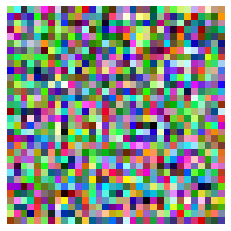

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# opt = get_argument().parse_args()

model_id = "1" # 模型ID
lamda = 0.01 # lamda值，影响NC的loss
while len(model_id)<4:
    model_id = "0"+model_id

f = open("/media/server/8961e245-931a-4871-9f74-9df58b1bd938/server/lyg/tdc-starter-kit-main/tdc_datasets/target_label_prediction/train/id-"+model_id+"/info.json", 'r')
info = json.load(f)
print(("Model ID:" + str(model_id)))
print(("Dataset:" + info['dataset']))

attack_specification = torch.load("/media/server/8961e245-931a-4871-9f74-9df58b1bd938/server/lyg/tdc-starter-kit-main/tdc_datasets/target_label_prediction/train/id-"+model_id+"/attack_specification.pt")

norm_list = []
flag_label = reverse_engineer(model_id, lamda)

minium_norm = float("inf")
minium_norm_index = float("inf")
for i in range(len(norm_list)):
    if norm_list[i]<minium_norm:
        minium_norm = norm_list[i]
        minium_norm_index = i%10
print("minium norm:"+str(minium_norm)+" and its index:"+str(minium_norm_index))
with open('train_results.txt','a+') as f:
    f.write("\n")
    f.write("Model ID:" + str(model_id))
    f.write("\n")
    f.write("Dataset:" + info['dataset'])
    f.write("\n")
    f.write("Attack type:" + info['trigger_type'])
    f.write("\n")
    f.write("Target Label:" + str(attack_specification['target_label']))
    f.write("\n")
    f.write(str(norm_list))
    f.write("\n")
    f.write("minium norm:"+str(minium_norm)+" and its index:"+str(minium_norm_index))
    f.write("\n")
    f.close()